<span style="font-size: 48px; font-weight: bold;">Algorytm BOinEA testowany na zbiorze NSL-KDD</span>

Spis treści

- [1](#1)- Zainstalowanie wymaganych pakietów
- [2](#2) - Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow
- [3](#3) - Załadowanie danych i normalizacja
- [4](#4) - Ocena zbalansowania zbioru
- [5](#5) - Wprowadzenie ważenia z powodu niezbalansowania zbioru, kategoryzacja etykiet
- [6](#6)- Zdefiniowanie CNN
- [7](#7) - Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście
- [8](#8) - Zdefiniowa funkcji celu
- [9](#9) - Zdefiniowanie defaltowych parametrów
- [10](#10) - Wykonanie  optymalizacji bayesowskiej za pomocą funkcji 
- [11](#11) - Wyświetlenie najlepszych wyników
- [12](#12) - Wykres konwergencji
- [13](#13) - Wykres wartości funkcji celu w każdej iteracji
- [14](#14) - Lista hiperparametrów dla kolejnych iteracji
- [15](#15) - Wykres plot_objective


### <a name='1'></a> 1. Zainstalowanie wymaganych pakietów

In [1]:
# !pip install scikit-learn
# !pip install scikit-optimize
# !pip install keras
# !pip install numpy
#!pip install sklearn

### <a name="2"></a> 2. Zaimportowanie bibliotek np.numpy, keras, skopt, tensorflow

In [2]:
import numpy as np
import random
import inspect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import time
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.utils.class_weight import compute_class_weight

from sklearn.utils import check_random_state
from skopt.utils import cook_estimator
from skopt.utils import normalize_dimensions
from skopt import Optimizer
from sklearn.utils import check_random_state

### <a name="3"></a> 3.Załadowanie danych i normalizacja


In [3]:


# pliki z danymi
train_file = "KDDTrain+.txt"
test_file  = "KDDTest+.txt"

# wczytanie danych
train_data = pd.read_csv(train_file, header=None, sep=",")
test_data  = pd.read_csv(test_file,  header=None, sep=",")

# odrzucenie ostatniej kolumny (liczba wskazująca trudność klasyfikacji)
train_data = train_data.iloc[:, :-1]
test_data  = test_data.iloc[:, :-1]

# Podział na cechy (X) i etykiety (y)
X = train_data.iloc[:, :-1]  
y = train_data.iloc[:, -1]   

X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

#podział na zbiór walidacyjny i testowy
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# identyfikacja kolumn kategorycznych i numerycznych
categorical_columns = X_train.select_dtypes(include=['object']).columns
numerical_columns   = X_train.select_dtypes(exclude=['object']).columns

# skalowanie cech numerycznych
scaler = MinMaxScaler()

# dopasowanie i transformacja tylko train:
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
# walidacja i zbiór testowy - transformacja
X_val[numerical_columns]   = scaler.transform(X_val[numerical_columns])
X_test[numerical_columns]  = scaler.transform(X_test[numerical_columns])

# kodowanie kolumn kategorycznych
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    
    # dopasowanie tylko na kolumnie treningowej
    X_train[col] = le.fit_transform(X_train[col])
    
    # transformacja walidacji
    X_val[col] = X_val[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    # Jeśli pojawiły się nowe wartości (=-1), rozszerzamy listę klas
    le_classes = list(le.classes_)
    if -1 in X_val[col].values:
        if -1 not in le_classes:
            le_classes.append(-1)
        le.classes_ = np.array(le_classes)
    # normalizacja do zakresu [0,1] (względem liczby klas)
    X_val[col] = X_val[col] / (len(le.classes_) - 1)
    
    # transformacja testu:
    X_test[col] = X_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    if -1 in X_test[col].values:
        if -1 not in le_classes:
            le_classes.append(-1)
        le.classes_ = np.array(le_classes)
    X_test[col] = X_test[col] / (len(le.classes_) - 1)
    
    # na końcu normalizacja X_train 
    X_train[col] = X_train[col] / (len(le.classes_) - 1)
    
    # zapisanie encodera
    label_encoders[col] = le

# kodowanie etykiet
label_encoder_y = LabelEncoder()
y_train = label_encoder_y.fit_transform(y_train)

# Walidacja
y_val = y_val.map(lambda s: label_encoder_y.transform([s])[0] if s in label_encoder_y.classes_ else -1)
# Test
y_test = y_test.map(lambda s: label_encoder_y.transform([s])[0] if s in label_encoder_y.classes_ else -1)


In [4]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,100778.000000,100778.000000,100778.000000,100778.000000,1.007780e+05,1.007780e+05,100778.000000,100778.000000,100778.000000,100778.000000,...,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000,100778.000000
mean,0.006665,0.526618,0.446962,0.698072,3.793482e-05,1.532717e-05,0.000198,0.007571,0.000040,0.002659,...,0.715022,0.453760,0.521310,0.083152,0.148470,0.032584,0.284380,0.278272,0.119008,0.120240
std,0.060309,0.213551,0.230640,0.268900,4.729777e-03,3.294335e-03,0.014086,0.084558,0.005144,0.027988,...,0.388767,0.434288,0.449156,0.189217,0.309445,0.112806,0.444741,0.445578,0.306821,0.319468
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.500000,0.289855,0.500000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.321569,0.039216,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.500000,0.347826,0.900000,3.188489e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.247059,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.500000,0.695652,0.900000,2.000052e-07,3.984923e-07,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,0.985507,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### <a name="4"></a> 4.Ocena zbalansowania zbioru

Text(0, 0.5, 'Number of images')

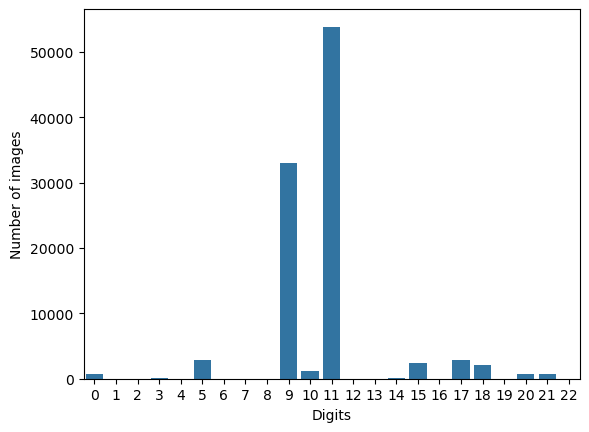

In [5]:
g = sns.countplot(x=y_train)
plt.xlabel('Digits')
plt.ylabel('Number of images')

### <a name="4"></a> 5. Wprowadzenie ważenia z powodu niezbalansowania zbioru, kategoryzacja etykiet

In [6]:


class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(y_train),  
    y=y_train                 
)
class_weights = dict(enumerate(class_weights))  



In [7]:
y_train = to_categorical(y_train, num_classes=23)
y_test = to_categorical(y_test, num_classes=23)
y_val = to_categorical(y_val, num_classes=23)



### <a name="6"></a> 6.Zdefiniowanie CNN

In [8]:

path_best_model = 'cnn_model.keras'
best_accuracy = 0



def create_cnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
    dropout_rate,
    
):
    """
    Hiperparametry:
    learning_rate:    Współczynnik uczenia dla optymalizatora.
    num_dense_layers: Liczba warstw w pełni połączonych (dense).
    num_dense_nodes:  Liczba neuronów w każdej warstwie dense.
    activation:       Funkcja aktywacji dla wszystkich warstw.
    dropout_rate:     Współczynnik Dropout, domyślnie 0.3.
    """

    model = Sequential()

    model.add(Input(shape=(41,)))
    
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
        
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(23, activation='sigmoid'))  

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',  
        metrics=['accuracy']
    )

    return model

### <a name="7"></a> 7.Zdefiniowanie przestrzeni hiperparametrów i umieszczenie hiperparametrów na liście

In [9]:
param_grid = {
    "learning_rate": (1e-6, 1e-2),               #
    "num_dense_layers": (1, 5),                 
    "num_dense_nodes": (10, 500), 
    "dropout_rate": (0.0, 0.5),              
    "activation": ["relu", "sigmoid", "tanh"],                    
}

### <a name="8"></a> 8.Zdefiniowa funkcji celu

### <a name="9 "></a> 9. Zdefiniowanie defaltowych parametrów

### <a name="10"></a> 10. Wykonanie  optymalizacji bayesowskiej za pomocą funkcji 


In [10]:
class Individual():
    """Klasa reprezentująca pojedyńczego osobnika,
        przechowuje wszystkie jego cechy"""
    def __init__(self,
                 learning_rate = None,
                 num_dense_layers =None,
                 num_dense_nodes = None,
                 activation = None,
                 num_conv_layers = None,
                 filter_size = None,
                 kernel_size = None,
                 dropout_rate = None,
                 evaluate_ind=-1
                 ):
        self.learning_rate = learning_rate
        self.num_dense_layers = num_dense_layers
        self.num_dense_nodes = num_dense_nodes
        self.activation = activation
        self.num_conv_layers = num_conv_layers
        self.filter_size = filter_size
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.evaluate_ind = evaluate_ind
        super().__init__()
    def __repr__(self):
        """Reprezentacja obiektu zawierająca wszystkie jego cechy."""
        return (
            f"Individual("
            f"learning_rate={self.learning_rate}, "
            f"num_dense_layers={self.num_dense_layers}, "
            f"num_dense_nodes={self.num_dense_nodes}, "
            f"activation={self.activation}, "
            f"num_conv_layers={self.num_conv_layers}, "
            f"filter_size={self.filter_size}, "
            f"kernel_size={self.kernel_size}, "
            f"evaluate_ind={self.evaluate_ind})"
        )

In [11]:
def mutation(individual: Individual, param_grid, p_m_con=0.2):
    """Metoda odpowiedzialna za mutacje"""

    # Pobranie wszystkich atrybutów, które nie są None
    non_none_attributes = {
        attr: value for attr, value in vars(individual).items() if value is not None
    }
    # Mutacja każdej zmiennej
    mutated_attributes = {}
    for attr, value in non_none_attributes.items():
        if attr in param_grid:  # Jeśli zmienna istnieje w param_grid
            if isinstance(param_grid[attr], tuple):  # Mutujemy tylko liczby
                mutated_attributes[attr] = mutate_variable(value, attr, param_grid, p_m_con=p_m_con)
            elif isinstance(param_grid[attr], list):  # Zmienna kategoryczna - bez mutacji
                mutated_attributes[attr] = value  # Przepisanie bez zmian
        else:
            mutated_attributes[attr] = value  # Przepisujemy wartości spoza param_grid bez zmian

    new_individual = Individual(**mutated_attributes)
    return new_individual


def mutate_variable(variable, variable_name, param_grid, length=30, p_m_con=0.2):
    """Metoda odpowiedzialna za mutację zmiennych ciągłych"""
    mutant_gene = variable
    if variable_name not in param_grid:
        raise ValueError(f"Zmienna '{variable_name}' nie istnieje w param_grid.")
    param = param_grid[variable_name]

    if isinstance(param, tuple):
        lower_bound, upper_bound = param
        # Obliczenie precyzji
        precision = (upper_bound - lower_bound) / ((2 ** length) - 1)
    else:
        raise ValueError(f"Zmienna '{variable_name}' nie jest numeryczna i nie może być mutowana.")

    #mutacja zmiennej ciągłej
    mutant_gene = encode_variable(mutant_gene,precision, lower_bound,length)
    for idx in range(len(mutant_gene)):
        if np.random.rand() < p_m_con:  # Prawdopodobieństwo mutacji
            if mutant_gene[idx] == 0:
                mutant_gene[idx] = 1
            else:
                mutant_gene[idx] = 0
    mutant_gene = decode_individual(mutant_gene, length,precision,lower_bound)
    if isinstance(variable, int):
        mutant_gene = int(round(mutant_gene))
    return mutant_gene

def encode_variable(value, precision, lower_bound, length):
    """Zakodowanie liczby do postaci bitowej"""
    shifted_value = (value - lower_bound) / precision
    int_value = int(round(shifted_value))
    binary_representation = [int(bit) for bit in bin(int_value)[2:].zfill(length)]

    return binary_representation

def decode_individual(individual, length, precision, lower_bound):
    """Dekoduje zakodowaną tablicę bitową na wartość rzeczywistą."""
    num_sum = sum(individual[-(i + 1)] * (2 ** i) for i in range(length))
    decoded_value = (num_sum * precision) + lower_bound
    return decoded_value


def crossover(parent_1: Individual, parent_2: Individual, param_grid, length=20):
    """Krzyżowanie dwóch osobników z uwzględnieniem typów cech i obliczaniem wartości `evaluate_ind`."""

    child_1_attributes = {}
    child_2_attributes = {}
    toggle = True  # Flaga do naprzemiennego przydzielania wartości cech kategorycznych

    for attr in param_grid:
        # Pomiń `evaluate_ind` w krzyżowaniu
        if attr == "evaluate_ind":
            continue

        # Pobierz wartości cechy dla obu rodziców
        value_1 = getattr(parent_1, attr)
        value_2 = getattr(parent_2, attr)

        # Jeśli cecha jest None, pomijamy ją
        if value_1 is None or value_2 is None:
            continue

        # Obsługa cech numerycznych
        if isinstance(param_grid[attr], tuple):  # Zakres wartości numerycznych
            lower_bound, upper_bound = param_grid[attr]
            precision = (upper_bound - lower_bound) / ((2 ** length) - 1)

            # Zakodowanie wartości
            binary_1 = encode_variable(value_1, precision, lower_bound, length)
            binary_2 = encode_variable(value_2, precision, lower_bound, length)

            # One-point crossover
            crossover_point = random.randint(1, length -14)
            child_binary_1 = binary_1[:crossover_point] + binary_2[crossover_point:]
            child_binary_2 = binary_2[:crossover_point] + binary_1[crossover_point:]

            # Dekodowanie wartości
            child_value_1 = decode_individual(child_binary_1, length, precision, lower_bound)
            child_value_2 = decode_individual(child_binary_2, length, precision, lower_bound)

            # Konwersja na int dla cech takich jak `num_dense_layers`
            if attr in ['num_dense_layers', 'num_dense_nodes', 'num_conv_layers']:
                child_value_1 = int(round(child_value_1))
                child_value_2 = int(round(child_value_2))

            # Przypisanie wartości do atrybutów
            child_1_attributes[attr] = child_value_1
            child_2_attributes[attr] = child_value_2

        # Obsługa cech kategorycznych
        elif isinstance(param_grid[attr], list):  # Lista kategoryczna
            if toggle:
                child_1_attributes[attr] = value_1
                child_2_attributes[attr] = value_2
            else:
                child_1_attributes[attr] = value_2
                child_2_attributes[attr] = value_1
            toggle = not toggle  # Zmiana flagi dla naprzemienności

    # Tworzenie potomków bez `evaluate_ind`
    child_1 = Individual(**child_1_attributes)
    child_2 = Individual(**child_2_attributes)

    return child_1, child_2

def tournament_selection(population, tournament_size=2):

    # Wybierz pierwszego rodzica
    candidates_1 = random.sample(population, tournament_size)
    parent_1 = max(candidates_1, key=lambda individual: individual.evaluate_ind)

    # Wybierz drugiego rodzica, upewniając się, że jest różny od pierwszego
    while True:
        candidates_2 = random.sample(population, tournament_size)
        parent_2 = max(candidates_2, key=lambda individual: individual.evaluate_ind)
        if parent_2 != parent_1:
            break
    return parent_1, parent_2

def individual_to_list(individual, space):
    """
    Przekształca obiekt `Individual` na listę wartości odpowiadającą przestrzeni `space`.
    Tylko cechy zdefiniowane w `space` zostaną uwzględnione.
    """
    # Wyciągnij nazwy parametrów ze space
    space_names = [dim.name for dim in space]

    # Zmapuj parametry individual do listy zgodnej z przestrzenią space
    return [getattr(individual, name) for name in space_names]


class GeneticAlgorithm:
    def __init__(self, param_grid, iteration=9, mutation_probability=0.1, population_size = 10):
        self.iteration = iteration
        self.list_num_iter = []
        self.best_solution_iter = []
        self.solution_iter = []
        self.param_grid = param_grid
        self.mutation_probability = mutation_probability
        self.path_best_model = 'cnn_model.h5'
        self.best_accuracy = 0
        self.best_hyperparameters = None
        self.solution_iter_genotype = []
        self.population_size=population_size
    

    def objective(self,learning_rate, num_dense_layers, num_dense_nodes,dropout_rate, num_conv_layers, filter_size, kernel_size, activation):
        

        print()
        print('Learning rate: {0:.1e}'.format(learning_rate))
        print('Number of dense layers:', num_dense_layers)
        print('Number of dense nodes:', num_dense_nodes)
        print('Activation:', activation)
        print('Dropout rate:', dropout_rate)
        print()


        X_train_array = X_train.values
        y_numeric = np.argmax(y_train, axis=1)
    
        skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
        val_accuracies = []
        
        for train_index, val_index in skf.split(X_train_array, y_numeric):
            X_fold_train, X_fold_val = X_train_array[train_index], X_train_array[val_index]
            y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

            model = create_cnn(
                learning_rate=learning_rate,
                num_dense_layers=num_dense_layers,
                num_dense_nodes=num_dense_nodes,
                dropout_rate=dropout_rate,
                activation=activation,
            )

            learning_rate_reduction = ReduceLROnPlateau(
                monitor='val_accuracy',
                patience=2,
                verbose=0,
                factor=0.5,
                min_lr=0.00001
            )
            early_stopping = EarlyStopping(
                monitor='val_accuracy',
                patience=3,
                restore_best_weights=True,
                verbose=0
            )

            history = model.fit(
                x=X_fold_train,
                y=y_fold_train,
                epochs=10,  
                batch_size=32,
                validation_data=(X_fold_val, y_fold_val),
                class_weight=class_weights,
                callbacks=[learning_rate_reduction, early_stopping],
                verbose=0
            )

        
            fold_val_accuracy = max(history.history['val_accuracy'])
            val_accuracies.append(fold_val_accuracy)


            del model

        mean_val_accuracy = np.mean(val_accuracies)
        print(f"Cross-Validation Accuracy: {mean_val_accuracy:.2%}\n")

        if mean_val_accuracy > self.best_accuracy:
            model = create_cnn(
                learning_rate=learning_rate,
                num_dense_layers=num_dense_layers,
                num_dense_nodes=num_dense_nodes,
                dropout_rate=dropout_rate,
                activation=activation,
                
            )
            model.fit(
                x=X_train_array,
                y=y_train,
                epochs=10,
                batch_size=32,
                validation_split=0.1,
                class_weight=class_weights,
                callbacks=[learning_rate_reduction, early_stopping],
                verbose=0
            )
            model.save(path_best_model)
            self.best_accuracy = mean_val_accuracy
            self.best_hyperparameters = {
                "learning_rate": learning_rate,
                "num_dense_layers": num_dense_layers,
                "num_dense_nodes": num_dense_nodes,
                "num_conv_layers": num_conv_layers,
                "filter_size": filter_size,
                "kernel_size": kernel_size,
                "dropout_rate": dropout_rate,
                "activation": activation
            }
            del model

        return mean_val_accuracy


    def first_generate_population(self,param_grid):
        population = []
        for _ in range(self.population_size):
            random_params = {}
            for param, values in param_grid.items():
                if isinstance(values, tuple):  # Zakres wartości liczbowych
                    random_params[param] = random.uniform(*values)
                    if isinstance(values[0], int):  # Jeśli to liczba całkowita
                        random_params[param] = int(round(random_params[param]))
                elif isinstance(values, list):  # Lista kategorii
                    random_params[param] = random.choice(values)
            individual = Individual(**random_params)
            # Oblicz `evaluate_ind` dla osobnika
            objective_args = inspect.signature(self.objective).parameters.keys()
            hyperparameters = {
                attr: value for attr, value in vars(individual).items() if attr in objective_args
            }
            individual.evaluate_ind = self.objective(**hyperparameters)
            population.append(individual)    
            self.best_solution_iter.append(self.best_accuracy)
        return population
    
    def define_search_space_around_individual(self, individual):
        search_space = [
            Real(
                low=max(1e-6, individual.learning_rate - 1e-4),
                high=min(1e-2, individual.learning_rate + 1e-4),
                prior='log-uniform',
                name='learning_rate'
            ),
            Integer(
                low=max(1, individual.num_dense_layers - 1),
                high=min(individual.num_dense_layers + 1, 5),
                name='num_dense_layers'
            ),
            Integer(
                low=max(10, individual.num_dense_nodes - 20),
                high=min(individual.num_dense_nodes + 20, 500),
                name='num_dense_nodes'
            ),
            Real(
                low=max(0.0, individual.dropout_rate - 0.05),
                high=min(0.5, individual.dropout_rate + 0.05),
                prior='uniform',
                name='dropout_rate'
        )
        ]
        return search_space

    def point_to_individual(self, point, space, best_individual=None):
        """
        Konwertuje listępunktu optimizer.ask() na obiekt Individual.
        Dla atrybutów, których nie ma w space, używamy  wartości z best_individual.
        """
        # Nazwy parametrów, które faktycznie bierzemy z `space`
        space_names = [dim.name for dim in space]

        # Zrobienie słownika z parametrami, które *są* w space
        param_dict = dict(zip(space_names, point))

        # Jeśli mamy `best_individual`, to dopełnij brakujące parametry
        if best_individual is not None:
            all_attrs = [
                "learning_rate",
                "num_dense_layers",
                "num_dense_nodes",
                "num_conv_layers",
                "filter_size",
                "kernel_size",
                "activation",
                "evaluate_ind"
                # cokolwiek jeszcze Individual może mieć
            ]
            for attr in all_attrs:
                # jeżeli w param_dict nie ma klucza `attr`, weź go z best_individual
                if attr not in param_dict:
                    param_dict[attr] = getattr(best_individual, attr, None)
        
        return Individual(**param_dict)


    def run(self):
        

        # Inicjalizacja populacji
        population = self.first_generate_population(self.param_grid)

        self.solution_iter = [individual.evaluate_ind for individual in population]
        self.solution_iter_genotype = [vars(individual) for individual in population]
        self.list_num_iter = [i for i in range(1,(self.iteration+1)*self.population_size+1 + (self.iteration-1)*10)]
        bayesian_flag = False
        iteration = 1
        for i in range(self.iteration):

            new_population = []
            # Generowanie nowej populacji
            for j in range(self.population_size//2):

                parent_1, parent_2 = tournament_selection(population)
                child_1, child_2 = crossover(parent_1, parent_2, self.param_grid)
                while vars(child_1) == vars(child_2):
                    child_1, child_2 = crossover(parent_1, parent_2, self.param_grid)

                if random.random() <= self.mutation_probability:
                    child_1 = mutation(child_1, self.param_grid)

                # Obliczenie oceny dla child_1
                objective_args = inspect.signature(self.objective).parameters.keys()
                hyperparameters_1 = {
                    attr: value for attr, value in vars(child_1).items()
                    if attr in objective_args
                }
                child_1.evaluate_ind = self.objective(**hyperparameters_1)

                if random.random() <= self.mutation_probability:
                    child_2 = mutation(child_2, param_grid)

                # Obliczenie oceny dla child_2
                hyperparameters_2 = {
                    attr: value for attr, value in vars(child_2).items()
                    if attr in objective_args
                }
                child_2.evaluate_ind = self.objective(**hyperparameters_2)

                new_population.append(child_1)
                self.best_solution_iter.append(self.best_accuracy)
                new_population.append(child_2)
                self.best_solution_iter.append(self.best_accuracy)
                self.solution_iter.append(child_1.evaluate_ind)
                self.solution_iter_genotype.append(vars(child_1))
                self.solution_iter.append(child_2.evaluate_ind)
                self.solution_iter_genotype.append(vars(child_2))
            population = new_population

            if bayesian_flag:
                self.best_individual = max(population, key=lambda individual: individual.evaluate_ind)

                space = self.define_search_space_around_individual(self.best_individual)
                
                random_state = None
                rng = check_random_state(random_state)
                space = normalize_dimensions(space)
                base_estimator = None
                if base_estimator is None:
                        base_estimator = cook_estimator(
                            "GP", space=space, random_state=rng.randint(0, np.iinfo(np.int32).max),
                            noise="gaussian")

                acq_optimizer_kwargs = {
                        "n_points": 10000, "n_restarts_optimizer": 5,
                        "n_jobs": 1}
                acq_func_kwargs = {"xi": 0.01, "kappa": 1.96}                

            
                optimizer = Optimizer(space, base_estimator = base_estimator,
                        n_initial_points=4,
                        initial_point_generator="random",
                        n_jobs=1,
                        acq_func="EI", acq_optimizer="lbfgs",
                        random_state=rng,
                        model_queue_size=None,
                        acq_optimizer_kwargs=acq_optimizer_kwargs,
                        acq_func_kwargs=acq_func_kwargs)


                optimizer.tell(individual_to_list(self.best_individual,space), -self.best_individual.evaluate_ind)
                bayes_candidates = []
                for n in range(10):
                    next_x = optimizer.ask()
                    # Stałe parametry z best_individual
                    static_params = [
                        self.best_individual.num_conv_layers,
                        self.best_individual.filter_size,
                        self.best_individual.kernel_size, 
                        self.best_individual.activation
                    ]

                    # Konkatenacja dynamicznych i stałych parametrów
                    point_rate = next_x + static_params
                    self.best_solution_iter.append(self.best_accuracy)
                    next_y = -self.objective(*point_rate)
                    optimizer.tell(next_x, next_y)
                    next_x = self.point_to_individual(next_x,space,self.best_individual)
                    next_x.evaluate_ind = -next_y
                    self.solution_iter_genotype.append(vars(next_x))
                    self.solution_iter.append(-next_y) 
                    bayes_candidates.append(next_x)


                best_bayes_candidate = max(bayes_candidates, key=lambda c: c.evaluate_ind)

                if best_bayes_candidate.evaluate_ind > self.best_individual.evaluate_ind:
                    idx = population.index(self.best_individual)
                    population[idx] = best_bayes_candidate
            bayesian_flag = True

            iteration += 1
        print("Najlepsze hiperparametry:", self.best_hyperparameters)
        print("Najlepsza dokładność:", self.best_accuracy)
        self.save_to_files()

    def save_to_files(self):
        """Zapisuje dane iteracji do plików CSV."""
        # Przygotowanie danych do pierwszego pliku
        solution_data = {
            "Iteration": self.list_num_iter,
            "Solutions": self.solution_iter
        }
        df_solutions = pd.DataFrame(solution_data)
        df_solutions.to_csv("solutions.csv", index=False)
        print("Zapisano plik: solutions.csv")

        genotype_data = []

        for i, genotype_dict in enumerate(
                self.solution_iter_genotype):  # Zakładamy, że self.solution_iter_genotype to lista słowników
            if isinstance(genotype_dict, dict):  # Upewnij się, że to słownik
                genotype_data.append({"Iteration": i + 1, **genotype_dict})
            else:
                print(f"Nieprawidłowy genotyp: {genotype_dict}")

        print("Wynik genotype_data:", genotype_data)

        df_genotypes = pd.DataFrame(genotype_data)
        df_genotypes.to_csv("genotypes.csv", index=False)
        print("Zapisano plik: genotypes.csv")



        # Przygotowanie danych do drugiego pliku
        best_solution_data = {
            "Iteration": self.list_num_iter,
            "Best Accuracy": self.best_solution_iter
        }
        df_best_solutions = pd.DataFrame(best_solution_data)
        df_best_solutions.to_csv("best_solutions.csv", index=False)
        print("Zapisano plik: best_solutions.csv")


if __name__ == "__main__":

    genetic_algorithm = GeneticAlgorithm(
        iteration = 5,
        param_grid = param_grid,
        mutation_probability=0.2,
        population_size=10
    )
    start_time = time.time()
    genetic_algorithm.run()
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"Czas wykonania funkcji run: {execution_time:.2f} sekund")



Learning rate: 8.7e-03
Number of dense layers: 1
Number of dense nodes: 324
Activation: tanh
Dropout rate: 0.13110260030759785

Cross-Validation Accuracy: 88.80%


Learning rate: 9.4e-03
Number of dense layers: 4
Number of dense nodes: 234
Activation: tanh
Dropout rate: 0.3802258546522309

Cross-Validation Accuracy: 72.17%


Learning rate: 8.4e-03
Number of dense layers: 5
Number of dense nodes: 152
Activation: relu
Dropout rate: 0.32557348262603325

Cross-Validation Accuracy: 39.53%


Learning rate: 1.2e-03
Number of dense layers: 3
Number of dense nodes: 84
Activation: relu
Dropout rate: 0.413856367621067

Cross-Validation Accuracy: 70.77%


Learning rate: 6.5e-03
Number of dense layers: 1
Number of dense nodes: 81
Activation: tanh
Dropout rate: 0.2960271973089027

Cross-Validation Accuracy: 88.18%


Learning rate: 7.5e-03
Number of dense layers: 1
Number of dense nodes: 292
Activation: relu
Dropout rate: 0.47916969605490095

Cross-Validation Accuracy: 87.04%


Learning rate: 2.6e-0

c:\Users\Jacek\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0.00941612497246263, 1, 393, 0.0789607324225735] before, using random point [0.009466217684454815, 1, 374, 0.08684445955533938]
  warnings.warn(


Cross-Validation Accuracy: 92.38%


Learning rate: 9.5e-03
Number of dense layers: 1
Number of dense nodes: 393
Activation: tanh
Dropout rate: 0.0789607324225735

Cross-Validation Accuracy: 88.26%


Learning rate: 9.6e-03
Number of dense layers: 1
Number of dense nodes: 370
Activation: tanh
Dropout rate: 0.07906794096568397

Cross-Validation Accuracy: 83.43%


Learning rate: 9.4e-03
Number of dense layers: 1
Number of dense nodes: 362
Activation: tanh
Dropout rate: 0.17888050373073383

Cross-Validation Accuracy: 90.34%


Learning rate: 9.1e-03
Number of dense layers: 3
Number of dense nodes: 114
Activation: tanh
Dropout rate: 0.47734490873044816

Cross-Validation Accuracy: 70.98%


Learning rate: 7.7e-03
Number of dense layers: 1
Number of dense nodes: 374
Activation: tanh
Dropout rate: 0.0802889681237647

Cross-Validation Accuracy: 88.58%


Learning rate: 5.8e-03
Number of dense layers: 3
Number of dense nodes: 495
Activation: relu
Dropout rate: 0.42827706451367314

Cross-Validation A

In [12]:
len(genetic_algorithm.list_num_iter)

100

### <a name="11"></a> 11. Wyświetlenie najlepszych wyników

- **Dokładność (accuracy):** wyświetlenie najlepszej osiągniętej dokładności.
- **Najlepsze hiperparametry:** wyświetlenie optymalnych wartości hiperparametrów.
- **Przestrzeń poszukiwań (gp_space):** analiza przestrzeni hiperparametrów.

In [13]:
print(f"Czas wykonania funkcji run: {execution_time:.2f} sekund")

Czas wykonania funkcji run: 6546.19 sekund


In [14]:
genetic_algorithm.best_accuracy

0.9283176958560944

In [15]:
genetic_algorithm.best_hyperparameters

{'learning_rate': 0.007011415971842239,
 'num_dense_layers': 1,
 'num_dense_nodes': 361,
 'num_conv_layers': None,
 'filter_size': None,
 'kernel_size': None,
 'dropout_rate': 0.05576174090451929,
 'activation': 'relu'}

### <a name="12"></a> 12. Wykres konwergencji




### <a name="13"></a> 13. Wykres wartości funkcji celu w każdej iteracji

### <a name="14"></a> 14. Lista hiperparametrów dla kolejnych iteracji

### <a name="15"></a> 15.Wykres plot_objective

### <a name="16"></a> 16. Testowanie modelu na zbiorze walidacyjnym, testowym